In [20]:
import re
import random
import pandas as pd
import hashlib

In [21]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].mean() > 80: age_factor = .5
else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1/age_factor) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.05

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [22]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Azure Private DNS,25.557937,1.345155,3.998866,19
IW Migration,221.877723,44.375545,60.035796,5
RAG Project,471.504238,29.469015,44.963265,16
Azure AD Authentication,682.959408,52.535339,110.302957,13
Azure DevOps Pipelines,931.132920,35.812805,100.096996,26
Azure Functions + Visual Studio,934.046707,71.849747,275.513992,13
Email Auth and Security,947.207538,78.933962,192.651355,12
Asynchronous Python,1011.456015,21.988174,36.429773,46
Open Source/GitHub,1040.691371,65.043211,181.658390,16
Todd Ideas,1071.164618,107.116462,269.718140,10


# Histogram

sum of ages: ~44080.27


<Axes: >

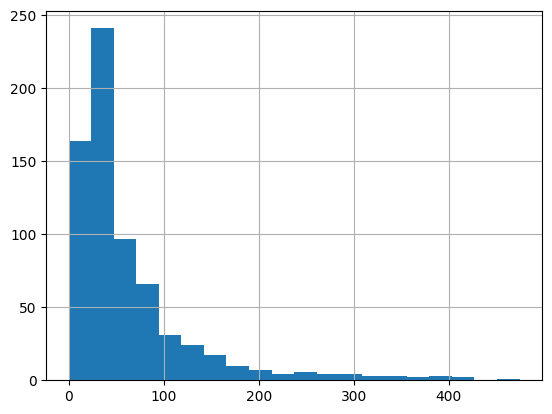

In [23]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [24]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [25]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [26]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

# Focus on one header

In [27]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [28]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [29]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [30]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [31]:
n=3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 689
Total card age: 44080.27


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
0,Azure Developer Associate,What must be configured on Application Gateway...,8ddf39df1182f81ce6e58790da23ef19,-474.393425,76.398578,474.393425,-5347.900493,0.346526,0,0
1,Azure Developer Associate,Q: Can the Standard tier of Azure Cache for Re...,438d86fb58de277f931a27a5e0aa1eea,-339.122509,76.398578,474.393425,-5347.900493,0.346526,3,0
2,Azure Developer Associate,When you copy an archived blob to a new blob i...,395e69a816df3423da56688d69a7bb90,-196.581668,76.398578,474.393425,-5347.900493,0.346526,6,0
3,Azure Developer Associate,There are two options for rehydrating a blob t...,e5fb56b88f231f744e8b59dbb9711288,-100.459146,76.398578,474.393425,-5347.900493,0.346526,9,0
236,Azure Developer Associate,What happens if one app in an App Service Plan...,482d0832927dfb0328c8d3516786e69a,-90.459001,76.398578,474.393425,-5347.900493,0.346526,12,0
237,Azure Developer Associate,How can you keep an Azure App Service always w...,7cfdc39b86ced2f8da8b14d344a73163,-81.790233,76.398578,474.393425,-5347.900493,0.346526,15,0
6,Azure Developer Associate,Which SDK allows you to log custom events in y...,16f6d5de6652f345ba51c8a33d54557d,-78.610242,76.398578,474.393425,-5347.900493,0.346526,18,0
239,Azure Developer Associate,Front: What are the three throughput models in...,b863718977efe0ff6bb86f3bf533dd15,-70.670040,76.398578,474.393425,-5347.900493,0.346526,21,0
8,Azure Developer Associate,Which service provides centralized telemetry a...,79d60158ab1f570660aa3dd1233b149a,-63.850383,76.398578,474.393425,-5347.900493,0.346526,24,0
463,Azure Developer Associate,To add a lifecycle management policy with Azur...,07f7bfa721d4ca721e328d5b8d558e28,-60.304377,76.398578,474.393425,-5347.900493,0.346526,27,0


## Age Mean

In [32]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)



## Age Max

In [33]:
# n = 1
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['age'] = existing_cards['age'] *-1
# # existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)
# existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [34]:
# n=10
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)




## Random

In [35]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [36]:
existing_cards.sort_values('age').head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
0,Azure Developer Associate,What must be configured on Application Gateway...,8ddf39df1182f81ce6e58790da23ef19,-474.393425,76.398578,474.393425,-5347.900493,0.346526,0,0
42,PnP PowerShell,Server Relative URL\nThe URL path relative to ...,8cf299b28aba8eeb49c675bc6fd23204,-406.495234,52.407155,406.495234,-3773.315156,0.527553,0,0
232,Azure Developer Associate,Q: Which tiers of Azure Cache for Redis are ba...,1dfb97906449c201f5bdfcd75cba1819,-405.100610,76.398578,474.393425,-5347.900493,0.346526,1,1
159,Debugging in VS Code,Debugger API\nAn application programming inter...,379ed80170d7da4e8ca2e7b1a4b9527c,-395.528287,80.480891,395.528287,-1529.136926,0.694736,0,0
273,PnP PowerShell,New-PnPList (PnP.PowerShell)\nCreates a new Sh...,9d9dc3700f5078d8eaff9507709eaacb,-382.235664,52.407155,406.495234,-3773.315156,0.527553,1,1
455,Azure Developer Associate,Q: What are key benefits of using Redis?\nA: U...,ec6a9d42ac7d9a2d5436a6dac663fde1,-381.997654,76.398578,474.393425,-5347.900493,0.346526,2,2
66,Logging in Python,Q: How can you configure Python's logging to o...,293e680688510b291b7b3691786112ec,-377.819709,106.080015,377.819709,-3712.800538,0.291140,0,0
171,Audit Report Tracker (Sharepoint List),Item (SharePoint List Item)\nDefinition: A sin...,d0ce8d0da3df8f92b4ff3ca95fd426ca,-369.578091,99.107326,369.578091,-1189.287910,0.311571,0,0
1,Azure Developer Associate,Q: Can the Standard tier of Azure Cache for Re...,438d86fb58de277f931a27a5e0aa1eea,-339.122509,76.398578,474.393425,-5347.900493,0.346526,3,0
24,JavaScript Concepts,Express.js: A minimalist web framework for Nod...,425c10164d26897fdad3f9d7c2c6f523,-337.157333,76.915597,337.157333,-4076.526658,0.048746,0,0


In [37]:
existing_cards.head(10).sum()

head                   Azure Developer AssociateAzure Developer Assoc...
body                   What must be configured on Application Gateway...
hash                   8ddf39df1182f81ce6e58790da23ef19438d86fb58de27...
age                                                         -1556.241024
subject_mean_age                                              763.985785
subject_highest_age                                          4743.934254
subject_age_sum                                            -53479.004929
head_random_roll                                                3.465263
count                                                                135
n_fold                                                                 0
dtype: object

In [38]:
existing_cards['age'].mean()

-63.97716789369153